In [1]:
# Algorithm:
# read the position and velocity data
# sort position data by Z-position

# For Longitudinal acoustic mode, use LA mode frequency from dispersion relation
# Calculate and add displacement in z-direction and velocity in the z-direction as well

# For Transverse acoustic mode along x-dirn, use TAx mode frequency from dispersion relation
# Calculate and add displacement in x-direction and velocity in the x-direction as well

# Remember the structure file produced will have atom id in floating point, put it into ovito
# save as atomic full style, then it will correct it. Just a final work around. But it will
# make all velocity values zero, so copy it from the original file created from here.

In [2]:
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cmath

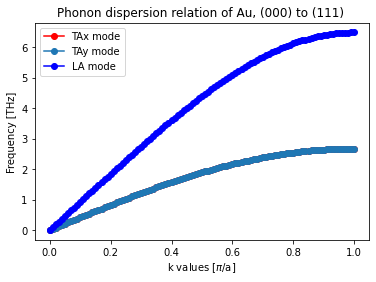

In [3]:
# Reading the phonon dispersion data:
filename = 'Au_morse.disp'
with open(filename, 'r') as file:
    lines = file.readlines()

data = [line.split() for line in lines if not line.startswith('#')]

data = np.array(data)
data = data.astype(np.float64)
cm_2_THz = 29979245800/1e12
TAx = data[0::3][:, 1]*cm_2_THz  # in (cm-1)
TAy = data[1::3][:, 1]*cm_2_THz  # in (cm-1)
LA = data[2::3][:, 1]*cm_2_THz   # in (cm-1)
k_val = (data[0::3][:, 0] - 1)/100

plt.plot(k_val, TAx, 'o-r', label='TAx mode')
plt.plot(k_val, TAy, 'o-', label='TAy mode')
plt.plot(k_val, LA, 'o-b', label='LA mode')
plt.xlabel('k values [$\pi$/a]')
plt.ylabel('Frequency [THz]')
plt.title('Phonon dispersion relation of Au, (000) to (111) ')
plt.legend()
plt.show()

In [4]:
# os.system('ls')

In [5]:
# Input variables:
relaxid = "417126"
ini_vel = 'yes'

# Structural variable:
relaxed_str = f'relaxed_structure_{relaxid}.lmp'

N_atoms = 478800         # Number of atoms
N_layeratom = 360        # Number of atoms in each Au(111) layer N_atoms/N_layer
offset_p = 38            # Lines to skip in data file
add_Au = 996             # Added Au layers
orig_Au = 0             # Existing Au layers
Au_plane_pbc = 22        # Number of Au layers that went to top due to PBC

N_plane = add_Au+orig_Au-Au_plane_pbc

# Phonon variables:
a0 = 4.079016               # lattice parameter of Au, a = 4.0782(lit), 4.07901835(calc)
A = 0.05                   # Amplitude of the wave in angstrom, 2e-3
eps_k0 = 1                  # e(k0) = Polarization wave vector, why 1?
val = 12                     # 5=0.05, 10 = 0.1, 20 =0.2, 30 = 0.3, 40 = 0.4           
# a = a0                       # Case-1     
# a = a0*np.sqrt(3)          # Case-2
a = a0/np.sqrt(3)            # Case-3
spatial_extent = 50
gamma = spatial_extent*a0    # Spatial extent


new_str = f'rlx_{relaxid}_A{A}_k{val}_G_{spatial_extent}a_{ini_vel}vel.lmp'

# Phonon dispersion relation values:
# These values should be obtained from Phonon-dispersion relation of Au 

k0 = k_val[val]*np.pi/a               # wave vector, k0 = 0.9*pi/a
w_LA = 2*np.pi*LA[val]           # in Hz, LA freq corresponding to k0 = 0.9*pi/a
w_TA = 2*np.pi*TAx[val]           # in Hz, TA freq corresponding to k0 = 0.9*pi/a


print("k-value", k_val[val],", LA freq:", LA[val],"THz", ", TA freq: ", TAx[val], "THz"); 

k-value 0.12 , LA freq: 1.1099186792873117 THz , TA freq:  0.5026506821736876 THz


In [6]:
with open(relaxed_str, "r") as file:   # jid=253256
    lines = file.readlines()
    total_lines = len(lines)
    print('Total lines:', total_lines)

# Read position data:
plines = lines[offset_p:(N_atoms+offset_p)]
# Extract data from line 38 to 384038
position = np.array([list(map(float, line.strip().split())) for line in plines])
print("Shape of position:", position.shape)

# Read velocity data:
offset_v = N_atoms+offset_p + 3
vlines = lines[offset_v:(N_atoms+offset_v)]
# Extract data from line 19 to 358579
velocity = np.array([list(map(float, line.strip().split())) for line in vlines])
print("Shape of velocity:", velocity.shape)

# Read bonds,angles, dihedrals data:
BAD = lines[(N_atoms+offset_v+1):] 

Total lines: 1317650
Shape of position: (478800, 10)
Shape of velocity: (478800, 4)


In [7]:
# Sorting the position according to Z-position:
sorted_index = np.argsort(position[:, 6])
position = position[sorted_index]            # col 4 = x, col 5 = y, col 6 = z

# # Sorting the velocity according to atomid:
# v_index = np.argsort(velocity[:, 0])    # sorting according to atom id
# velocity = velocity[v_index];
# vx = velocity[:, 1]
# vy = velocity[:, 2]
# vz = velocity[:, 3]

Maximum Z-position: 3351.6439674373137
Minimum Z-position: 8.400308075656195


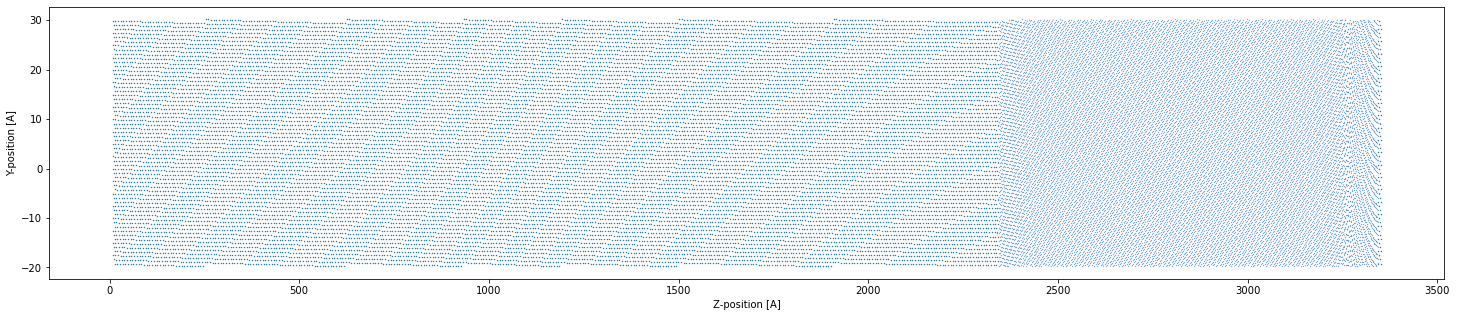

In [8]:
maxZ = np.max(position[:, 6]); print('Maximum Z-position:', maxZ)
minZ = np.min(position[:, 6]); print('Minimum Z-position:', minZ)

# position[:, 6] = position[:, 6] - minZ       # shifting the lower limit to zero

plt.figure(figsize =(25, 5))
plt.plot(position[:, 6], position[:, 5], '.', markersize=0.1)
plt.xlabel('Z-position [A]')
plt.ylabel('Y-position [A]')
plt.show()

In [9]:
dplane = a0/np.sqrt(3)                 # Distance between Au(111) planes

Au_bottom = np.min(position[:, 6])      # Bottom layer of Au     
Au_top = Au_bottom + dplane*N_plane +40.5     # Top layer of Au

print('Top layer of Au:', Au_top)
print('Bottom layer of Au:', Au_bottom)

# Selecting position within Au_bottom and Au_top:
Au_111_layers = position[position[:, 6] < Au_top]
MNL_layers = position[position[:, 6] > Au_top]

print("No. of Au planes:", Au_111_layers.shape[0]/N_layeratom)
print("No. of Au atoms:", Au_111_layers.shape[0])

Top layer of Au: 2342.6907480780983
Bottom layer of Au: 8.400308075656195
No. of Au planes: 992.0
No. of Au atoms: 357120


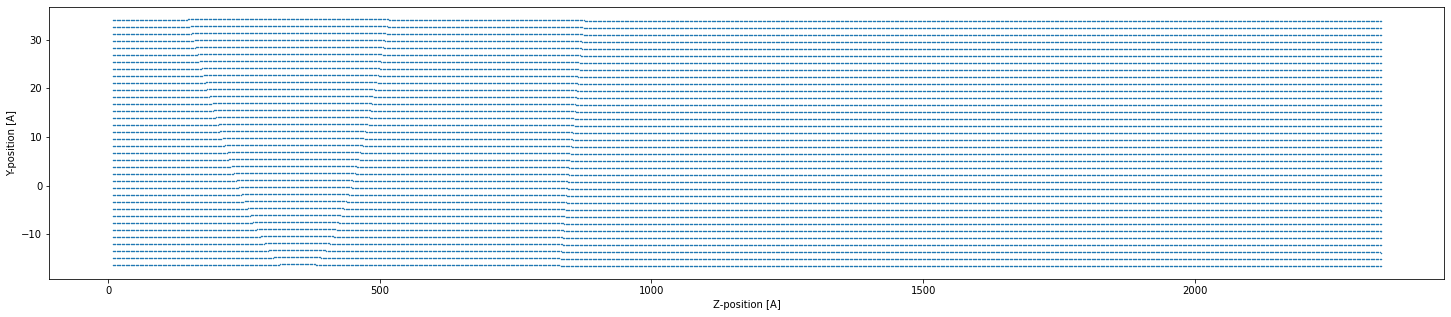

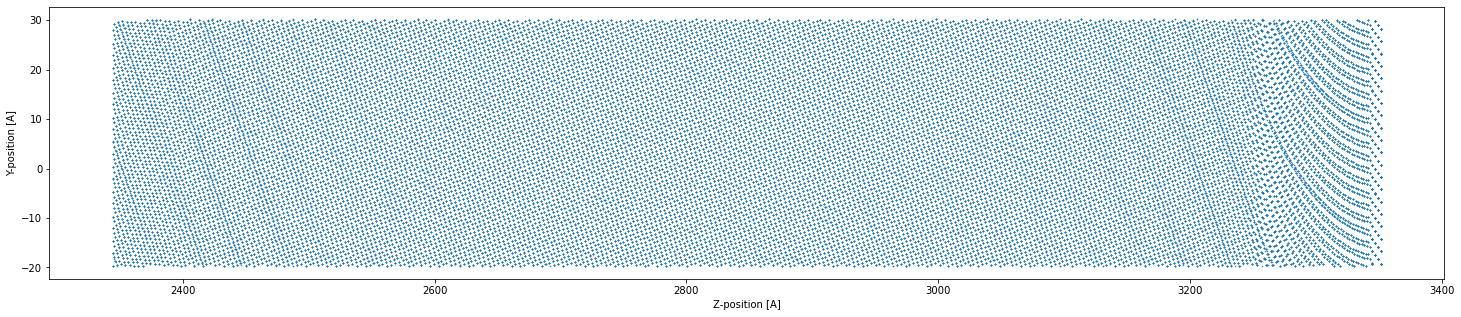

In [10]:
# Extracted Au_111_layers only for phonon launching:
plt.figure(figsize =(25, 5))
plt.plot(Au_111_layers[:, 6], Au_111_layers[:, 4], '.', markersize=0.2)
plt.xlabel('Z-position [A]')
plt.ylabel('Y-position [A]')
plt.show()

# Remaining Au_111_layers and MNL layers:
plt.figure(figsize =(25, 5))
plt.plot(MNL_layers[:, 6], MNL_layers[:, 5], '.', markersize=1)
plt.xlabel('Z-position [A]')
plt.ylabel('Y-position [A]')
plt.show()

In [11]:
N_layers = Au_111_layers.shape[0] // N_layeratom   # Number of Au layers

# initialize the new array
Au_layers = np.zeros((N_layers, 1)) # Creating empty array

# loop over the number of averages
for i in range(N_layers):
    start = i * N_layeratom
    end = (i + 1) * N_layeratom
    
    # calculate the average of every 360 rows
    avg = np.mean(position[start:end, 6], axis=0)
    
    # store the average in the new array
    Au_layers[i, 0] = avg
Au_layers = Au_layers.reshape(-1)         

In [12]:
# Computing the displacements
xn = Au_layers                             # All positions
x0 = xn[xn.shape[0]//2 - 220]      # middle of the Au layer, for 2600 A

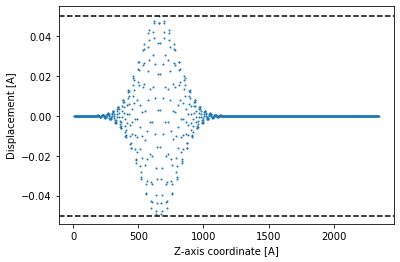

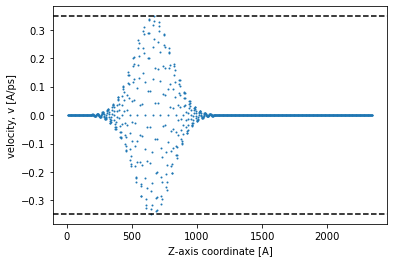

In [13]:
y = 0 + k0*(xn - x0)*1j
disp = A*eps_k0*np.exp(-(xn - x0)**2/gamma**2)*np.exp(y)

# Plot the position
U = np.real(disp)                        # Take the real part for displacement
plt.plot(xn, U, 'o', markersize=1, label='real')
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("Displacement [A]")
# plt.xlim(800, 900)
# plt.ylim(-0.2, 0.2)
plt.axhline(A, color='k', ls='--')
plt.axhline(-A, color='k', ls='--')
plt.savefig("Wave-packet_displacement.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()


# Plot the velocity
vel = (w_LA*np.imag(disp))           # For LA mode set this as velocity in z-dirn, A/ps            
plt.plot(xn, vel, 'o', markersize=1, )
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("velocity, v [A/ps]")
plt.axhline(A*w_LA, color='k', ls='--')
plt.axhline(-A*w_LA, color='k', ls='--')
plt.savefig("Wave-packet_velocity.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
# plt.xlim(500, 550)
# plt.ylim(-0.5, 0.5)
plt.show()

# np.savetxt("Wave-packet_displacement.dat", U)
# np.savetxt("Wave-packet_velocity.dat", vel) 

In [14]:
# Repeating each of these values 360 times for all the atoms in each Au layer
new_pos = (U.reshape(U.shape[0], 1) @ np.ones(N_layeratom).reshape(1, N_layeratom)).flatten()
new_vel = (vel.reshape(vel.shape[0], 1) @ np.ones(N_layeratom).reshape(1, N_layeratom)).flatten()

In [15]:
# Now let's do the replacement of both position and velocity:

# position
# Adding displacement to the Z-position 
# new_z = position[:, 6] + new_pos
Au_111_layers[:, 6] = 1.0000000000*new_pos + 1.0000000000*Au_111_layers[:, 6]

phonon_pos = Au_111_layers[:, 0:7]                     # only taking from 0 to 6th column
p_index = np.argsort(phonon_pos[:, 0])
phonon_pos = phonon_pos[p_index]

min_val = -8 * 1e-12
max_val = 8 * 1e-12

# # # # Generate an array of random numbers in the given range
# Au_vel = np.zeros((Au_111_layers.shape[0], 4))
# Au_vel[:, 0] = Au_111_layers[:, 0]                 # atom ids
# Au_vel[:, 1] = np.random.uniform(min_val, max_val, size=(Au_111_layers.shape[0]))    # vx = 0 A/ps
# Au_vel[:, 2] = np.random.uniform(min_val, max_val, size=(Au_111_layers.shape[0]))    # vy = 0 A/ps
# Au_vel[:, 3] = np.random.uniform(min_val, max_val, size=(Au_111_layers.shape[0]))


# velocity of displaced atoms only
# replacing vz component of velocity, vx = vy = 0 A/ps for LA mode
Au_vel = np.zeros((Au_111_layers.shape[0], 4))
Au_vel[:, 0] = Au_111_layers[:, 0]                 # atom ids
Au_vel[:, 1] = np.zeros(Au_111_layers.shape[0])    # vx = 0 A/ps
Au_vel[:, 2] = np.zeros(Au_111_layers.shape[0])    # vy = 0 A/ps
# Au_vel[:, 3] = np.zeros(Au_111_layers.shape[0])
Au_vel[:, 3] = 1.0000000000*new_vel                # vz = computed velocity

# Note: new_vel and velocity has different shape, new_vel has shape of Au_111_layers
# But velocity has the shape of total no. of atoms, so, if you have to provide velocity
# first add velocity for Au atoms then provide zero velocity to rest of the atoms.

# Sorting the velocity according to atomid:
v_index = np.argsort(Au_vel[:, 0])
Au_vel = Au_vel[v_index];

# Velocity of non-displaced atoms:
MNL_vel = np.zeros((MNL_layers.shape[0], 4))
MNL_vel[:, 0] = MNL_layers[:, 0]                 # atom ids
MNL_vel[:, 1] = np.random.uniform(min_val, max_val, size=(MNL_layers.shape[0]))    # vx = 0 A/ps
MNL_vel[:, 2] = np.random.uniform(min_val, max_val, size=(MNL_layers.shape[0]))    # vy = 0 A/ps
MNL_vel[:, 3] = np.random.uniform(min_val, max_val, size=(MNL_layers.shape[0]))    # vz = computed velocity

# # # Velocity of non-displaced atoms:
# MNL_vel = np.zeros((MNL_layers.shape[0], 4))
# MNL_vel[:, 0] = MNL_layers[:, 0]                 # atom ids
# MNL_vel[:, 1] = np.zeros(MNL_layers.shape[0])    # vx = 0 A/ps
# MNL_vel[:, 2] = np.zeros(MNL_layers.shape[0])    # vy = 0 A/ps
# MNL_vel[:, 3] = np.zeros(MNL_layers.shape[0])    # vz = computed velocity

In [16]:
# os.system('rm Au_111_18x10x332*.lmp')

with open(new_str, "w") as output_file:
    
# Writing the structural details, natoms, box size
    for i in range(0, 21):
        output_file.write(lines[i])
    
    for i in range(36, 38):
        output_file.write(lines[i])

# Writing the position of atoms:        
    for item in phonon_pos:   # Au atoms with displacement
        output_file.write(str(int(item[0]))+ '\t' + str(int(item[1]))+ '\t' +
                          str(int(item[2]))+ '\t' + 
                          '\t'.join(str(elem) for elem in item[3:]) + '\n')

    for item in MNL_layers[:, 0:7]:   # Remaining atoms with position
        output_file.write(str(int(item[0]))+ '\t' + str(int(item[1]))+ '\t' +
                          str(int(item[2]))+ '\t' + 
                          '\t'.join(str(elem) for elem in item[3:]) + '\n')
# Writing velocities:
    output_file.write("\n")
    output_file.write("Velocities"+ "\n")
    output_file.write("\n")    
    for item in Au_vel:
        output_file.write(str(int(item[0]))+ '\t' + '\t'.join(str(elem) for elem in item[1:]) + '\n')
    for item in MNL_vel:
        output_file.write(str(int(item[0]))+ '\t' + '\t'.join(str(elem) for elem in item[1:]) + '\n')

# Writing bonds, angles, dihedrals        
    output_file.write("\n")
    for i in range((N_atoms+offset_v+1), len(lines)):
        output_file.write(lines[i])
        
    output_file.write("\n")
    
# np.savetxt("Velocity.dat", velocity)
# np.savetxt("Displacement.dat", phonon_pos)


In [17]:
print('Input paramters:')
print('k-value:', k_val[val])
print('Selected frequency:', LA[val], 'THz')
print('Lattice parameter:', a, 'Ang')
print('Center of wave packet:', x0)

Input paramters:
k-value: 0.12
Selected frequency: 1.1099186792873117 THz
Lattice parameter: 2.3550209856287907 Ang
Center of wave packet: 658.3198939377544


In [18]:
import glob
import shutil

# Making the directory the wave-packet:
directory_path = os.getcwd()

foldername = f'rlxid_{relaxid}_A{A}_k{val}_G_{spatial_extent}a_{ini_vel}vel'        # Folder name

new_directory_path = os.path.join(directory_path, foldername)
if not os.path.exists(new_directory_path):
    os.makedirs(new_directory_path)

# Move all the *.tif files to the new directory
tif_files = glob.glob("*.png")
for file in tif_files:
    shutil.move(file, os.path.join(new_directory_path, file))

shutil.move(new_str, os.path.join(new_directory_path, new_str))

'/mnt/c/Users/rajan/OneDrive - Missouri State University/Hard_drive_2/RPI_Courseworks/Courseworks/CSCI-6930-Materials_Informatics/Research_scripts/Phonon_thermal_simulation/Au_996_C1000/rlxid_417126_A0.05_k12_G_50a_yesvel/rlx_417126_A0.05_k12_G_50a_yesvel.lmp'

In [19]:
# # Sorting the position according to Z-position:
# sorted_index = np.argsort(Au_111_layers[:, 6])
# Au_111_layers = Au_111_layers[sorted_index]            # col 4 = x, col 5 = y, col 6 = z
# np.savetxt("z_disp_vel.dat", np.hstack((Au_111_layers[:, 6][:, None], phonon_pos[:, 6][:, None])))

# # Creating directory and moving file:
# os.system('mkdir A002_k10_abysqrt3')
# os.system('mv *.dat *.png *.lmp A002_k10_abysqrt3')